# Exploratory Data Analysis
We'll load the training dataset and inspect its head and columns.

In [3]:
import pandas as pd

train_path = "../data/train.csv"
df = pd.read_csv(train_path)

print(df.head(2))
print(df.columns)

      id             model_a     model_b  \
0  30192  gpt-4-1106-preview  gpt-4-0613   
1  53567           koala-13b  gpt-4-0613   

                                              prompt  \
0  ["Is it morally right to try to have a certain...   
1  ["What is the difference between marriage lice...   

                                          response_a  \
0  ["The question of whether it is morally right ...   
1  ["A marriage license is a legal document that ...   

                                          response_b  winner_model_a  \
0  ["As an AI, I don't have personal beliefs or o...               1   
1  ["A marriage license and a marriage certificat...               0   

   winner_model_b  winner_tie  
0               0           0  
1               1           0  
Index(['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b',
       'winner_model_a', 'winner_model_b', 'winner_tie'],
      dtype='str')


/tmp/ipykernel_165417/1600627488.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, labels=["Losing response", "Winning response", "Tie response"], showfliers=False)


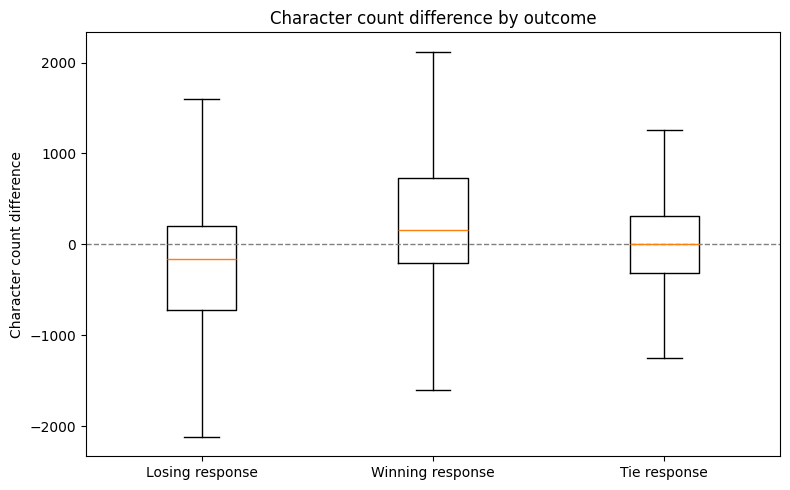

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def _detect_response_cols(columns):
    col_set = set(columns)
    if {"response_a", "response_b"}.issubset(col_set):
        return "response_a", "response_b"
    if {"response_1", "response_2"}.issubset(col_set):
        return "response_1", "response_2"
    response_cols = [c for c in columns if "response" in c.lower() and "id" not in c.lower() and "len" not in c.lower()]
    if len(response_cols) >= 2:
        return response_cols[0], response_cols[1]
    raise ValueError("Could not find response columns. Please update the column detection.")

def _detect_winner_series(dataframe):
    col_set = set(dataframe.columns)
    one_hot_options = [
        ("winner_model_a", "winner_model_b", "winner_tie"),
        ("winner_a", "winner_b", "winner_tie"),
        ("winner_response_a", "winner_response_b", "winner_tie"),
    ]
    for a_col, b_col, t_col in one_hot_options:
        if {a_col, b_col, t_col}.issubset(col_set):
            winner = dataframe[[a_col, b_col, t_col]].idxmax(axis=1)
            return winner.map({a_col: "a", b_col: "b", t_col: "tie"})

    if "winner" in col_set:
        def _normalize(val):
            v = str(val).strip().lower()
            if "tie" in v or v in {"tie", "draw", "neither"}:
                return "tie"
            if v in {"a", "model_a", "winner_model_a", "response_a"} or "model_a" in v or "response_a" in v:
                return "a"
            if v in {"b", "model_b", "winner_model_b", "response_b"} or "model_b" in v or "response_b" in v:
                return "b"
            return np.nan
        return dataframe["winner"].map(_normalize)

    raise ValueError("Could not find winner columns. Please update the winner detection.")

response_a_col, response_b_col = _detect_response_cols(df.columns)
winner = _detect_winner_series(df)

len_a = df[response_a_col].fillna("").astype(str).str.len()
len_b = df[response_b_col].fillna("").astype(str).str.len()
diff = len_a - len_b

winner_diff = pd.Series(np.nan, index=df.index)
loser_diff = pd.Series(np.nan, index=df.index)
winner_diff[winner == "a"] = diff[winner == "a"]
winner_diff[winner == "b"] = -diff[winner == "b"]
loser_diff[winner == "a"] = -diff[winner == "a"]
loser_diff[winner == "b"] = diff[winner == "b"]
tie_diff = diff[winner == "tie"]

plot_data = [
    loser_diff.dropna(),
    winner_diff.dropna(),
    tie_diff.dropna(),
]

plt.figure(figsize=(8, 5))
plt.boxplot(plot_data, labels=["Losing response", "Winning response", "Tie response"], showfliers=False)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.ylabel("Character count difference")
plt.title("Character count difference by outcome")
plt.tight_layout()
plt.show()

In [14]:
import numpy as np

def permutation_test_mean_diff(a, b, n=2000, seed=42):
    a = np.asarray(a.dropna())
    b = np.asarray(b.dropna())
    if len(a) == 0 or len(b) == 0:
        return np.nan, np.nan
    obs = a.mean() - b.mean()
    combined = np.concatenate([a, b])
    rng = np.random.default_rng(seed)
    count = 0
    for _ in range(n):
        perm = rng.permutation(combined)
        new_a = perm[: len(a)]
        new_b = perm[len(a) :]
        if abs(new_a.mean() - new_b.mean()) >= abs(obs):
            count += 1
    p_value = (count + 1) / (n + 1)
    return obs, p_value

obs_diff, p_val = permutation_test_mean_diff(winner_diff, loser_diff)
print("Character count difference test (winner vs loser):")
print(f"Mean diff (winner - loser): {obs_diff:.4f}")
print(f"Permutation p-value: {p_val:.4f}")

Character count difference test (winner vs loser):
Mean diff (winner - loser): 531.0835
Permutation p-value: 0.0005


/tmp/ipykernel_165417/279582785.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(jac_plot_data, labels=["Losing response", "Winning response", "Tie response"], showfliers=False)


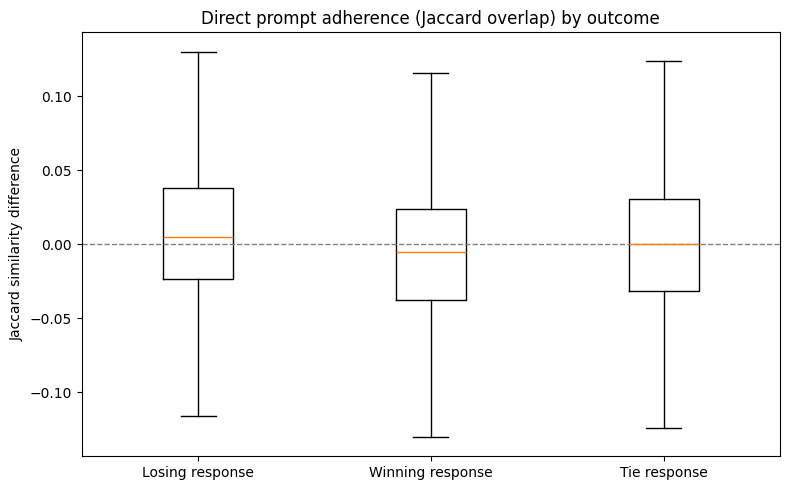

In [12]:
import re
import numpy as np
import matplotlib.pyplot as plt

def _detect_prompt_col(columns):
    col_set = set(columns)
    for name in ["prompt", "instruction", "question", "query"]:
        if name in col_set:
            return name
    text_cols = [c for c in columns if any(k in c.lower() for k in ["prompt", "instruction", "question", "query"]) ]
    if text_cols:
        return text_cols[0]
    raise ValueError("Could not find prompt/instruction column. Please update the column detection.")

prompt_col = _detect_prompt_col(df.columns)

token_re = re.compile(r"\b\w+\b")
def jaccard_similarity(a: str, b: str) -> float:
    if not a and not b:
        return 0.0
    a_tokens = set(token_re.findall(a.lower()))
    b_tokens = set(token_re.findall(b.lower()))
    if not a_tokens and not b_tokens:
        return 0.0
    return len(a_tokens & b_tokens) / len(a_tokens | b_tokens)

prompt_text = df[prompt_col].fillna("").astype(str)
jac_a = (
    df[response_a_col].fillna("").astype(str)
    .combine(prompt_text, jaccard_similarity)
)
jac_b = (
    df[response_b_col].fillna("").astype(str)
    .combine(prompt_text, jaccard_similarity)
)
jac_diff = jac_a - jac_b

jac_winner_diff = pd.Series(np.nan, index=df.index)
jac_loser_diff = pd.Series(np.nan, index=df.index)
jac_winner_diff[winner == "a"] = jac_diff[winner == "a"]
jac_winner_diff[winner == "b"] = -jac_diff[winner == "b"]
jac_loser_diff[winner == "a"] = -jac_diff[winner == "a"]
jac_loser_diff[winner == "b"] = jac_diff[winner == "b"]
jac_tie_diff = jac_diff[winner == "tie"]

jac_plot_data = [
    jac_loser_diff.dropna(),
    jac_winner_diff.dropna(),
    jac_tie_diff.dropna(),
]

plt.figure(figsize=(8, 5))
plt.boxplot(jac_plot_data, labels=["Losing response", "Winning response", "Tie response"], showfliers=False)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.ylabel("Jaccard similarity difference")
plt.title("Direct prompt adherence (Jaccard overlap) by outcome")
plt.tight_layout()
plt.show()

In [16]:
obs_diff_jac, p_val_jac = permutation_test_mean_diff(jac_winner_diff, jac_loser_diff)
print("Prompt adherence (Jaccard) test (winner vs loser):")
print(f"Mean diff (winner - loser): {obs_diff_jac:.6f}")
print(f"Permutation p-value: {p_val_jac:.4f}")

Prompt adherence (Jaccard) test (winner vs loser):
Mean diff (winner - loser): -0.013856
Permutation p-value: 0.0005


/tmp/ipykernel_165417/455874092.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(sim_plot_data, labels=["A wins", "B wins", "Tie"], showfliers=False)


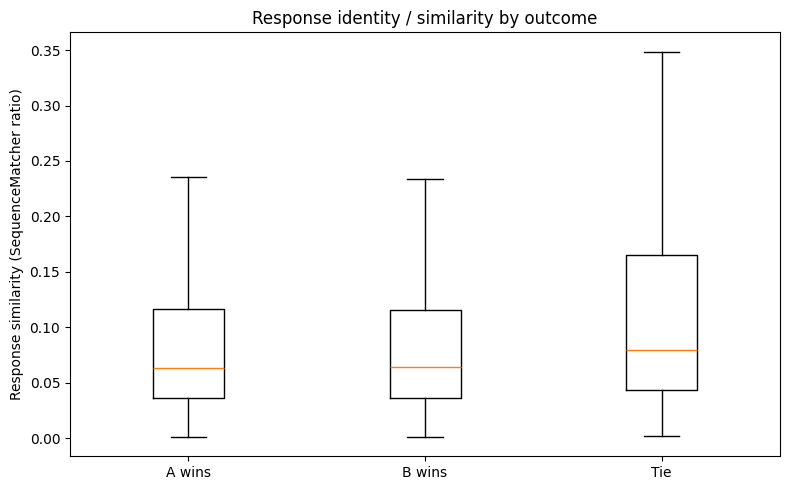

In [13]:
from difflib import SequenceMatcher
import matplotlib.pyplot as plt

def similarity_ratio(a: str, b: str) -> float:
    if not a and not b:
        return 1.0
    return SequenceMatcher(None, a, b).ratio()

resp_a = df[response_a_col].fillna("").astype(str)
resp_b = df[response_b_col].fillna("").astype(str)
sim = resp_a.combine(resp_b, similarity_ratio)

sim_a_wins = sim[winner == "a"]
sim_b_wins = sim[winner == "b"]
sim_tie = sim[winner == "tie"]

sim_plot_data = [
    sim_a_wins.dropna(),
    sim_b_wins.dropna(),
    sim_tie.dropna(),
]

plt.figure(figsize=(8, 5))
plt.boxplot(sim_plot_data, labels=["A wins", "B wins", "Tie"], showfliers=False)
plt.ylabel("Response similarity (SequenceMatcher ratio)")
plt.title("Response identity / similarity by outcome")
plt.tight_layout()
plt.show()

In [17]:
sim_non_tie = pd.concat([sim_a_wins, sim_b_wins])
obs_diff_sim, p_val_sim = permutation_test_mean_diff(sim_tie, sim_non_tie)
print("Response similarity test (tie vs non-tie):")
print(f"Mean diff (tie - non-tie): {obs_diff_sim:.6f}")
print(f"Permutation p-value: {p_val_sim:.4f}")

Response similarity test (tie vs non-tie):
Mean diff (tie - non-tie): 0.050188
Permutation p-value: 0.0005


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# Build feature matrix from selected features
X_model = pd.DataFrame({
    'char_count_diff': diff,
    'jaccard_diff': jac_diff,
    'response_similarity': sim,
})

# Target: 0 = A wins, 1 = B wins, 2 = Tie
label_map = {"a": 0, "b": 1, "tie": 2}
y_model = winner.map(label_map).astype(int)

# Remove rows with missing values
valid_idx = X_model.notna().all(axis=1) & y_model.notna()
X_clean = X_model[valid_idx].reset_index(drop=True)
y_clean = y_model[valid_idx].reset_index(drop=True)

print(f"\nModel Input Shape: {X_clean.shape}")
print(f"Target Distribution:")
for label, count in y_clean.value_counts().sort_index().items():
    label_name = ['A wins', 'B wins', 'Tie'][label]
    print(f"  {label_name}: {count:,} ({100*count/len(y_clean):.1f}%)")

# Train/test split (same as heuristic_gbm.ipynb)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

print(f"\nTrain size: {len(X_train):,}")
print(f"Test size: {len(X_test):,}")

# Train XGBoost model
model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0,
)

model.fit(X_train, y_train)

# Evaluate on test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("\n" + "="*60)
print("MODEL PERFORMANCE (Test Set)")
print("="*60)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification report
print("\nClassification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=['A wins', 'B wins', 'Tie'],
    digits=4
))

# Feature importances
importances = pd.Series(
    model.feature_importances_,
    index=X_clean.columns
).sort_values(ascending=False)

print("\nFeature Importances:")
for feat, imp in importances.items():
    print(f"  {feat:30s}: {imp:.4f}")


Model Input Shape: (57477, 3)
Target Distribution:
  A wins: 20,064 (34.9%)
  B wins: 19,652 (34.2%)
  Tie: 17,761 (30.9%)

Train size: 45,981
Test size: 11,496

MODEL PERFORMANCE (Test Set)
Accuracy: 0.4501 (45.01%)

Classification Report:
              precision    recall  f1-score   support

      A wins     0.4665    0.5181    0.4909      4013
      B wins     0.4692    0.4983    0.4833      3931
         Tie     0.3966    0.3198    0.3541      3552

    accuracy                         0.4501     11496
   macro avg     0.4441    0.4454    0.4428     11496
weighted avg     0.4458    0.4501    0.4461     11496


Feature Importances:
  char_count_diff               : 0.5455
  response_similarity           : 0.2679
  jaccard_diff                  : 0.1866
